### Forecast experiment 3 - Electricity production data

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

# in time series forecasting, we usually need to scale our values
# for better end results
from sklearn.preprocessing import MinMaxScaler

In [88]:
# let's try a pandas DataFrame instead
df = pd.read_csv("Electric_Production.csv")

In [89]:
df

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [90]:
# for easier and more dynamic code, save the value column name here
value_column = 'IPG2211A2N'

**Before going any further, scale the values in our DataFrame**

In [91]:
# scale the values with MinMaxScaler so that we don't
# affect the distribution of data (thus making the signal not realistic anymore)
# MinMaxScaler is a good solution here
scaler = MinMaxScaler()
df[[value_column]] = scaler.fit_transform(df[[value_column]])

# as weird as it sounds, scaling the index/sequence number also
# to be a decimal might affect the performance of the network
df = df.drop("DATE", axis=1)
df.index = df.index * 0.1 + 1

In [92]:
df

,IPG2211A2N
1.0,0.232017
1.1,0.207274
1.2,0.096304
1.3,0.029104
1.4,0.000000
...,...
40.2,0.584431
40.3,0.516922
40.4,0.567161
40.5,0.801813


In [93]:
# let's figure out a good cutoff point for train/test
# 67% for training, 25% testing (NOTE: you should experiment on this to find optimal %)
cutoff = int(len(df) * 0.8)

# train data
X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df[value_column].iloc[cutoff:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# in this case, number of variables is 1 => scaled passengers value
n_features = 1

# use reshape tools to get the data ready for future use
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))


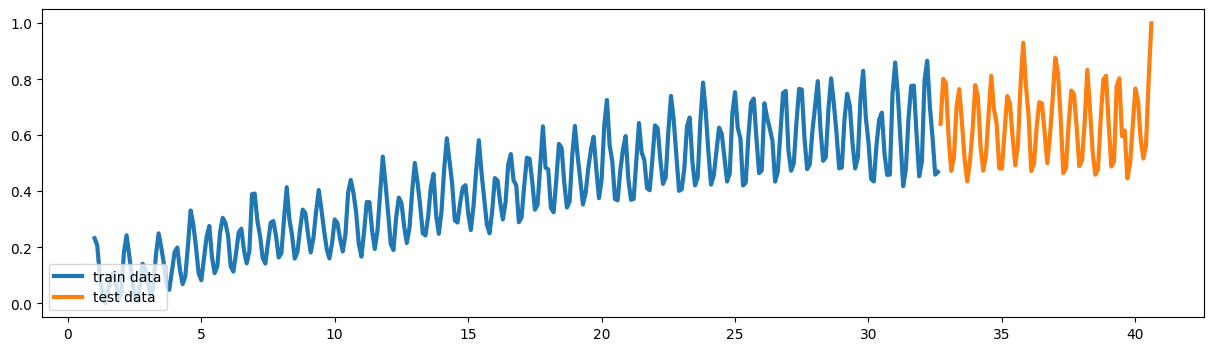

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [95]:
from tensorflow.keras.utils import timeseries_dataset_from_array

# the variable that determines how many points
# back into the past the model attempts to learn
look_back  = 16
batch_size = 1
window_size = 1

# stride = 1 => means we use separate time steps
# more than 1 => we use windowing

# THIS IS USING THE MORE MODERN TENSORFLOW DATASETS
# INSTEAD OF THE ORIGINAL TIMESERIES GENERATORS
# TimeseriesGenerator is deprecated and will be removed in future
# Tensorflow versions, but nobody knows exactly when that happens

# unfortunately, the TF datasets and the original TimeseriesGenerators
# do the same thing in THEORY, but in practice, they function in a different
# manner when feeding the training data into the neural network while training

train_generator = timeseries_dataset_from_array(
    data=train_series,
    targets=train_series[look_back:],
    sequence_length=look_back,
    sampling_rate=1,
    sequence_stride=window_size,
    batch_size=batch_size,
    shuffle=False,
)

test_generator = timeseries_dataset_from_array(
    data=test_series,
    targets=test_series[look_back:],
    sequence_length=look_back,
    sampling_rate=1,
    sequence_stride=window_size,
    batch_size=batch_size,
    shuffle=False,
)


In [96]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_electricity_ver2.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

# build the neural network
# in this case, LSTM with 8 neurons
n_neurons  = 64

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(LSTM(n_neurons, activation="relu"))

# alternatively, we might try adding regularization here as well
# so add to the Dense-layer => kernel_regularizer=keras.regularizers.l1(l1=0.1)
# might need some experimentation, whether L1, L2 or L1/L2 is the best one
# and if you need to increase the regularization rate to be above 0.1
model.add(Dense(16, activation="relu"))

# due to the differences how TF datasets and Timeseries Generators 
# actually work and feed the data to the neural network
# you usually need to increase regularization when switching to TF datasets
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# it's not optimal to use test data as validation data
# because this might skew our metrics
# see the other version of this notebook on how to do
# train/validation/test -split for the sine wave
model.fit(train_generator, epochs=150, verbose=1, validation_data=test_generator, callbacks=callback_list)


Epoch 1/150
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0279 - val_loss: 0.0193
Epoch 2/150
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0263 - val_loss: 0.0181
Epoch 3/150
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0226 - val_loss: 0.0242
Epoch 4/150
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0196 - val_loss: 0.0183
Epoch 5/150
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0189 - val_loss: 0.0182
Epoch 6/150
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0179 - val_loss: 0.0200
Epoch 7/150
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0167 - val_loss: 0.0182
Epoch 8/150
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0157 - val_loss: 0.0184
Epoch 9/150
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0129
Epoch 10/150
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0102
Epoch 11/150
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0095
Epoch 12/150
301/301 ━━━━━━━━━━━━━━━━━━━━

**Training metrics**

<Axes: >

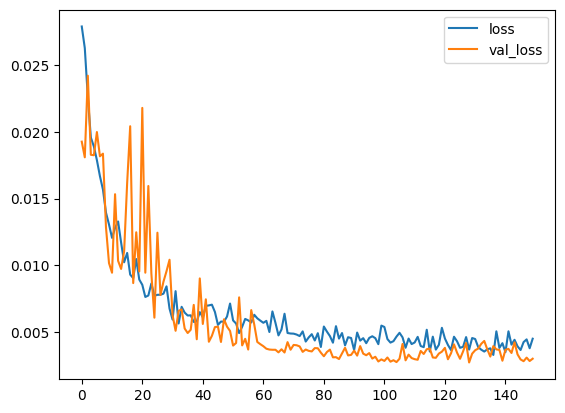

In [97]:
# the usual training metrics visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [98]:
# reload the best version of the model
from keras.models import load_model
model = load_model("best_model_electricity_ver2.keras")

In [99]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# these values are very close to each other, 
# which means our model is quite optimal
# IN THEORY 

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0032
Training loss: 0.003249148139730096
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027    
Testing loss: 0.002739241346716881


**Test predictions**

In [100]:
test_predictions  = model.predict(test_generator)

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


**Conventional regression metrics + MAPE**

In [101]:
# let's make a separate copy of the test values
# so we can calculate some errors

actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
6.19 %

MAE
0.04 units

MSE
0.0 units^2

RMSE:
0.05 units

R-squared:
0.84


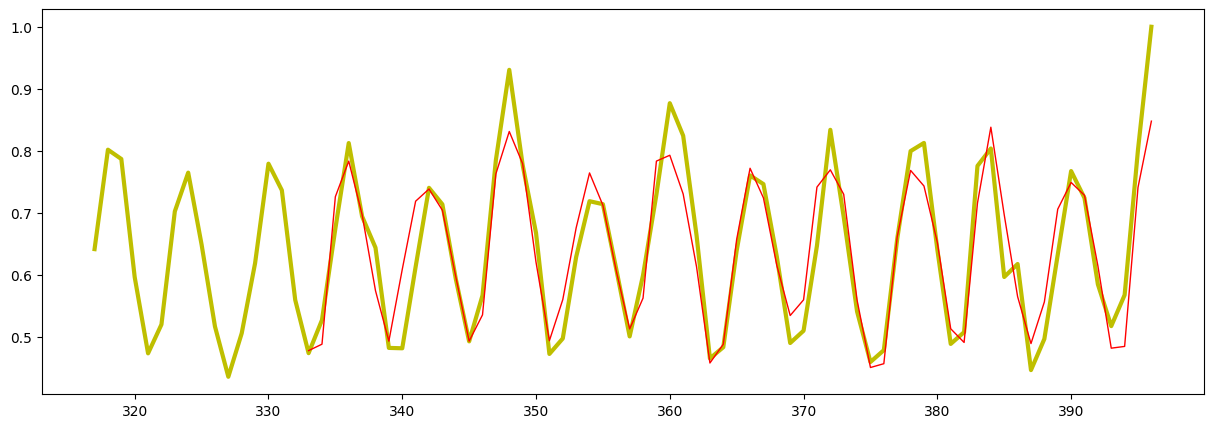

In [102]:
# calculate helper x-variables for where the train data starts
# where the test data starts and where the predictions start
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

In [103]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# some difference here which we can see in the test-signal prediction already 

301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032
Training loss: 0.003249148139730096
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027    
Testing loss: 0.002739241346716881


**Extrapolation into the future**

In [104]:
# EXTRAPOLATION TEST 1 - 180 new points
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(120):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

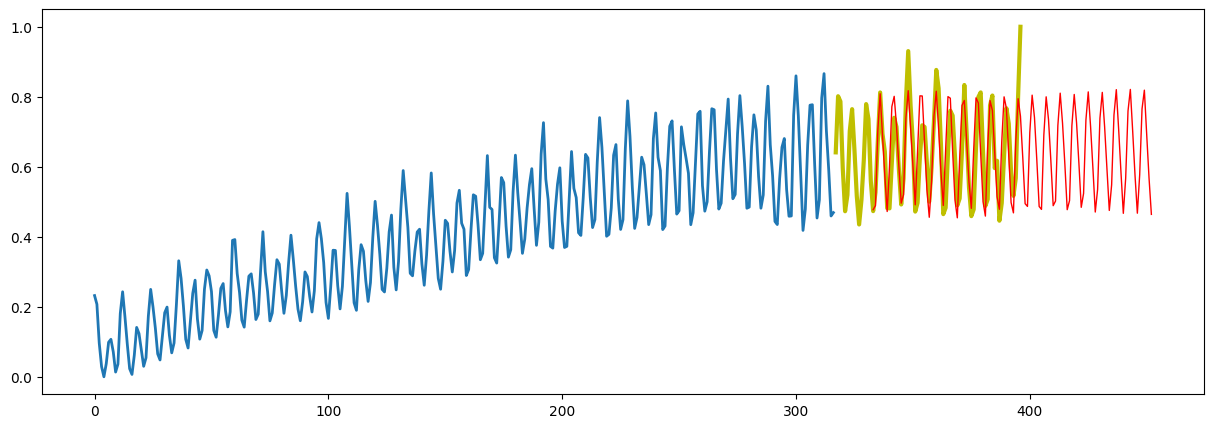

In [105]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()